# Определение стоимости автомобилей

Задача определить рыночную стоимость автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Важные критерии:

- качество;
- скорость;
- время обучения.

## Подготовка данных

### Импорт библиотек

Импортуруем необходимые библиотеки и установим дополнительно `LightGBM` !pip install lightgbm -U

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split # Деление на выборки

from sklearn.linear_model import LinearRegression # модель линейной регрессии
from sklearn.tree import DecisionTreeRegressor # модель дерева решений для регрессии
from sklearn.ensemble import RandomForestRegressor # модель случайного леса для регрессии

from sklearn.metrics import mean_squared_error # метрики MSE и RMSE ( RMSE = mse ** 0.5)

from sklearn.preprocessing import OrdinalEncoder # Порядковое кодирование
from sklearn.preprocessing import StandardScaler # Стандартизация (Масштабирование признаков)

# установка библиотеки LightGBM
#!pip install lightgbm -U

from lightgbm import LGBMRegressor # модель LightGBM для регрессии

from matplotlib import pyplot as plt #визуализациЯ данных

In [3]:
pd.options.display.float_format = '{:,.1f}'.format # уменьшим число знаков при отображении в блоктоте

### Описание данных

Данные находятся в файле `autos.csv`.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- **Price** — цена (евро)


In [747]:
df = pd.read_csv('autos.csv') #загрузим данные
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [748]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

`Вывод:`

Данные содержат пропуски и текстовые поля. Категориальные параметры необходимо будет перевести в числа для работы с моделями регрессии.

In [749]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.0","354,369.0","354,369.0","354,369.0","354,369.0","354,369.0","354,369.0"
mean,"4,416.7","2,004.2",110.1,"128,211.2",5.7,0.0,"50,508.7"
std,"4,514.2",90.2,189.9,"37,905.3",3.7,0.0,"25,783.1"
min,0.0,"1,000.0",0.0,"5,000.0",0.0,0.0,"1,067.0"
25%,"1,050.0","1,999.0",69.0,"125,000.0",3.0,0.0,"30,165.0"
50%,"2,700.0","2,003.0",105.0,"150,000.0",6.0,0.0,"49,413.0"
75%,"6,400.0","2,008.0",143.0,"150,000.0",9.0,0.0,"71,083.0"
max,"20,000.0","9,999.0","20,000.0","150,000.0",12.0,0.0,"99,998.0"


`Вывод:`

Данные содержат аномальные значения в признаках Price = 0  и Power > 600 л.с. и Power < 10 л.с.

Проверим распределение значений в признаках.

In [750]:
for col in df.columns:
    print('столбец: ', '\033[1m'+ col + '\033[0m', '---------------')
    print(df[col].value_counts())

столбец:  DateCrawled ---------------
2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-23 13:50:19    5
                      ..
2016-03-20 16:48:06    1
2016-03-22 21:51:04    1
2016-03-11 16:25:36    1
2016-03-31 12:47:30    1
2016-03-19 18:57:12    1
Name: DateCrawled, Length: 271174, dtype: int64
столбец:  Price ---------------
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64
столбец:  VehicleType ---------------
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
столбец:  RegistrationYear ---------------
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001     

### Удаляем лишние столбцы:

- DateCrawled
- LastSeen
- DateCreated
- NumberOfPictures
- DateCreated

Эти столбцы не содержат информации связанной с Ценой.

In [751]:
df = df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'DateCreated'], axis=1)

### Удаляем аномальные значения Price  < 1 тыс. руб.

In [752]:
df = df.query('Price > 1')
df.shape[0]

342408

### Удаляем аномальные  значения Power > 600

In [753]:
df = df.query('Power <= 600')
df.shape[0]

342052

### Удаляем пропуски в значениях признаков NaN

In [754]:
df = df.dropna().reset_index(drop=True)
df.shape[0]

241946

In [755]:
df # проверим результат

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
1,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
2,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
3,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
4,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,96224
...,...,...,...,...,...,...,...,...,...,...,...,...
241941,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,81825
241942,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,96465
241943,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624
241944,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135


In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241946 entries, 0 to 241945
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              241946 non-null  int64 
 1   VehicleType        241946 non-null  object
 2   RegistrationYear   241946 non-null  int64 
 3   Gearbox            241946 non-null  object
 4   Power              241946 non-null  int64 
 5   Model              241946 non-null  object
 6   Kilometer          241946 non-null  int64 
 7   RegistrationMonth  241946 non-null  int64 
 8   FuelType           241946 non-null  object
 9   Brand              241946 non-null  object
 10  NotRepaired        241946 non-null  object
 11  PostalCode         241946 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 22.2+ MB


### Возраст авто
У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, введем признак "тип возраста" (ретро, супер-ретро, старая, новая)

Группируем средню стоимость по возрасту авто.

In [757]:
group_price = df.groupby(['RegistrationYear']).agg(mean_Price=('Price','mean'))

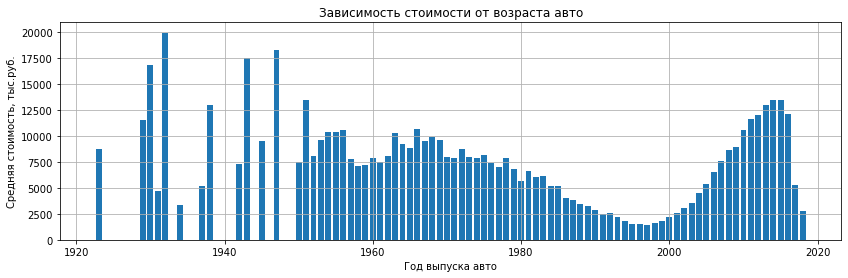

In [758]:
plt.figure(figsize=(14, 4))
plt.bar(group_price.index, group_price['mean_Price'])

#подписи осей
plt.xlabel('Год выпуска авто')
plt.ylabel('Средняя стоимость, тыс.руб.')

#заголовок
plt.title('Зависимость стоимости от возраста авто')

plt.grid(True)

plt.show()

Как видно из графика стоимость авто после 30 лет начинает расти.

Создадим категорию "тип возраста":

- до 1960 - `супер ретро`
- 1961 .. 1990 - `ретро`
- 1991 .. 2011 - `старая`
- 2012 .. н.в - `новая`

Создадим новый столбец `тип_возраста`

In [759]:
df['тип_возраста'] = 'новая'
df.loc[df['RegistrationYear'] < 2012, 'тип_возраста'] = 'старая'
df.loc[df['RegistrationYear'] < 1991, 'тип_возраста'] = 'ретро'
df.loc[df['RegistrationYear'] < 1961, 'тип_возраста'] = 'супер ретро'

In [760]:
df.groupby(['тип_возраста']).agg(mean_Year=('RegistrationYear','mean')) # проверим результ

,mean_Year
тип_возраста,
новая,"2,012.9"
ретро,"1,983.7"
старая,"2,002.9"
супер ретро,"1,952.6"


### Переводим категориальные признаки из текста в цифры:

Сохраним dataframe для проверки работы с категориальными признаками в модели LGBMRegressor 

In [761]:
df2 = df.copy()

#### Ordinal Encoding
Что бы закодировать цифрами выраженные в тексте категории используем  **Ordinal Encoding**.

1. Фиксируется, какой цифрой кодируется класс;
2. Цифры размещаются в столбце.

Преобразуем только столбцы с текстовым форматом.

In [762]:
encoder = OrdinalEncoder()

columns_ordinal = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'тип_возраста'] # спискок столцов, которые нужно преобразовать.

df_ordinal = pd.DataFrame(encoder.fit_transform(df[columns_ordinal]), columns=df[columns_ordinal].columns)

df[columns_ordinal] = df_ordinal[columns_ordinal] #заменяем значения признаков в оригинальном DataFrame
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,тип_возраста
0,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0,91074,2.0
1,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,60437,2.0
2,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,33775,2.0
3,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,67112,2.0
4,2000,4.0,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,96224,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241941,3999,7.0,2005,1.0,3,11.0,150000,5,2.0,2.0,0.0,81825,2.0
241942,3200,4.0,2004,1.0,225,140.0,150000,5,6.0,30.0,1.0,96465,2.0
241943,1150,0.0,2000,1.0,0,248.0,150000,3,6.0,24.0,0.0,26624,2.0
241944,1199,1.0,2000,0.0,101,106.0,125000,3,6.0,32.0,0.0,26135,2.0


In [763]:
df.info() #проверим формат данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241946 entries, 0 to 241945
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              241946 non-null  int64  
 1   VehicleType        241946 non-null  float64
 2   RegistrationYear   241946 non-null  int64  
 3   Gearbox            241946 non-null  float64
 4   Power              241946 non-null  int64  
 5   Model              241946 non-null  float64
 6   Kilometer          241946 non-null  int64  
 7   RegistrationMonth  241946 non-null  int64  
 8   FuelType           241946 non-null  float64
 9   Brand              241946 non-null  float64
 10  NotRepaired        241946 non-null  float64
 11  PostalCode         241946 non-null  int64  
 12  тип_возраста       241946 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 24.0 MB


### Разделим выборку
на обучающую и валидационную случайным образом в пропорции 3:1:1

Поскольку подбор гиперпараметров выполняется на валидационной выборке - нам понадобится тестовая для окончательного сравнения качества моделей.

Извлечем `признаки` и целевой признак

In [764]:
target = df['Price']
features = df.drop('Price', axis=1)

Разделим исходные данные на обучающую, валидационную и тестовую выборки в рекомендованной пропорции 3:1:1. Для этого вначале разделим на две части в пропорции 1:4.

In [765]:
features_part, features_test, target_part, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) # отделим 20% (1/5) данных для тестовой выборки

Вторым шагом разделим на две части в пропорции 1:3.

In [766]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_part, target_part, test_size=0.25, random_state=12345) # отделим 25% (1/4) данных для валидации

Проверим `результат разбиения` данных:

In [767]:
features_train.shape, features_valid.shape, features_test.shape # проверим результат разбиения

((145167, 12), (48389, 12), (48390, 12))

### Масштабирование признаков

Поскольку в данных присутствуют колличественные признаки с разными разбросами значений, то алгорим может решить, что признаки с большими значениями и разбросом важнее. Чтобы избежать этой ловушки, используем метод масштабирования — **стандартизации данных** — приводим к одному масштабу.

Обучение проведим на тестовых данных, затем применяем модель стандартизации ко всем признакам, кроме целевых.

In [768]:
scaler = StandardScaler()
scaler.fit(features_train) # обучаем на тестовых данных.

features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns, index=features_train.index)
features_valid = pd.DataFrame(scaler.transform(features_valid ), columns=features_valid.columns, index=features_valid.index)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns, index=features_test.index)

### Вывод по Подготовке данных:

Удалили лишние столбцы
- DateCrawled, LastSeen, DateCreated, NumberOfPictures, DateCreated.

Удалили аномалии в данных:
- Price < 1 и Power > 600 и Power < 10;
- строки с Nan.

Выполнили преобразование: 
- перевести текст в цифру;
- Выполнили нормализацию.

Число строк уменьшилось на 30%.

## Обучение моделей

Проверим результаты предсказаний различных моделей: 

### **LinearRegression** модель линейной регрессии

####  Скорость обучения

In [769]:
%%time
model = LinearRegression() # инициализируем модель LinearRegression
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

Wall time: 104 ms


LinearRegression()

#### Скорость предсказания

In [770]:
%%time
predictions_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке

result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # посчитаем значение метрики RMSE на валидационной выборке
print("RMSE модели линейной регрессии на валидационной выборке: {:.1f}".format(result))

RMSE модели линейной регрессии на валидационной выборке: 2860.2
Wall time: 7.98 ms


#### Результат на тестовой выборке

In [771]:
%%time
predictions_test = model.predict(features_test) # получим предсказания модели на валидационной выборке

result = mean_squared_error(target_test, predictions_test) ** 0.5 # посчитаем значение метрики RMSE на валидационной выборке
print("RMSE модели линейной регрессии на тестовой выборке: {:.1f}".format(result))

RMSE модели линейной регрессии на тестовой выборке: 2845.6
Wall time: 9.97 ms


**`RMSE LinearRegression`** на валидационной выборке:
- Обучение **`78.1 ms`**
- Предсказание **`6.98 ms`**
- RMSE  =  **`2873.9`**  - большое значение ошибки.

### **DecisionTreeRegressor** - модель дерева решений для регрессии

#### Подбор гиперпараметров

In [772]:
%%time

best_model = None
best_result = 10000
best_depth = 0
for depth in range(13, 14):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    # инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("RMSE наилучшей модели на валидационной выборке: {:.1f}".format(best_result), "Глубина дерева: {:.1f}".format(best_depth))

RMSE наилучшей модели на валидационной выборке: 1920.5 Глубина дерева: 13.0
Wall time: 1.01 s


**`DecisionTreeRegressor`** на валидационной выборке: `Wall time: 860 ms` и `RMSE  = ` **`1889.7`**

#### Скорость обучения:

In [773]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=13)
# инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

Wall time: 913 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

#### Скорость предсказаня:

In [774]:
%%time
predictions_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели на валидационной выборке: {:.1f}".format(result), "Глубина дерева: {:.1f}".format(13))

RMSE наилучшей модели на валидационной выборке: 1920.5 Глубина дерева: 13.0
Wall time: 27.4 ms


#### Результат на тестовой выборке

In [775]:
%%time
predictions_test = model.predict(features_test) # получим предсказания модели на валидационной выборке
result = mean_squared_error(target_test, predictions_test) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели на тестовой выборке: {:.1f}".format(result), "Глубина дерева: {:.1f}".format(13))

RMSE наилучшей модели на тестовой выборке: 1902.0 Глубина дерева: 13.0
Wall time: 22.9 ms


**`DecisionTreeRegressor`** на тестовой выборке:
- Обучение **` 924  ms`**
- Предсказание **`28.9 ms`**
- RMSE  =  **`1902.0`** 

#### График важности факторов

Для понимания какие факторы оказались важны при моделировании используем feature_importances_ и отразим значения на графике. 

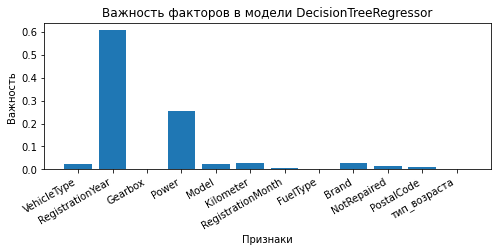

In [776]:
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(features_test.columns, model.feature_importances_)
fig.autofmt_xdate()

#подписи осей
plt.xlabel('Признаки')
plt.ylabel('Важность')

#заголовок
plt.title('Важность факторов в модели DecisionTreeRegressor')

plt.show()

### **RandomForestRegressor** - модель случайного леса для регрессии

#### Подбор гиперпараметров

In [777]:
%%time

best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(13, 14, 1):
    for depth in range (14, 15):
        model = RandomForestRegressor(random_state=12345, n_estimators=est,
                max_depth=depth)# инициализируем модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке: {:.1f}".format(best_result),
      "Количество деревьев: {:.1f}".format(best_est), "Максимальная глубина: {:.1f}".format(depth))

RMSE наилучшей модели на валидационной выборке: 1681.8 Количество деревьев: 13.0 Максимальная глубина: 14.0
Wall time: 8.82 s


**`RandomForestRegressor `** на валидационной выборке: `Wall time: 8.06 s` и `RMSE  = ` **`1665.6`**

#### Скорость обучения:

In [778]:
%%time

model = RandomForestRegressor(random_state=12345, n_estimators=13,
                max_depth=14)# инициализируем модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

Wall time: 8.5 s


RandomForestRegressor(max_depth=14, n_estimators=13, random_state=12345)

#### Скорость предсказания:

In [779]:
%%time
predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели на валидационной выборке: {:.1f}".format(result),
      "Количество деревьев: {:.1f}".format(13), "Максимальная глубина: {:.1f}".format(14))

RMSE наилучшей модели на валидационной выборке: 1681.8 Количество деревьев: 13.0 Максимальная глубина: 14.0
Wall time: 189 ms


#### Результат на тестовой выборке

In [780]:
%%time
predictions_test = model.predict(features_test) # предсказания модели на валидационной выборке
result = mean_squared_error(target_test, predictions_test) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели на тестовой выборке: {:.1f}".format(result),
      "Количество деревьев: {:.1f}".format(13), "Максимальная глубина: {:.1f}".format(14))

RMSE наилучшей модели на тестовой выборке: 1656.1 Количество деревьев: 13.0 Максимальная глубина: 14.0
Wall time: 179 ms


**`RandomForestRegressor `** на тестовой выборке:
- Обучение **`8460 ms`** - большое время обучения
- Предсказание **`182 ms`**
- RMSE  =  **`1656.1`**

#### График важности факторов

Для понимания какие факторы оказались важны при моделировании используем feature_importances_ и график. 

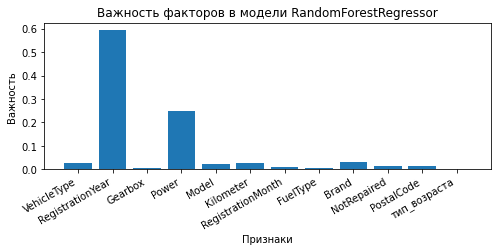

In [781]:
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(features_test.columns, model.feature_importances_)
fig.autofmt_xdate()

#подписи осей
plt.xlabel('Признаки')
plt.ylabel('Важность')

#заголовок
plt.title('Важность факторов в модели RandomForestRegressor')

plt.show()

### **LGBMRegressor** -  модель LightGBM для регрессии

#### Параметры по умолчанию.

In [782]:
%%time

model = LGBMRegressor()

model.fit(features_train, target_train) # обучим модель на тренировочной выборке
predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE LGBMRegressor валидационной выборке: {:.1f}".format(result))

RMSE LGBMRegressor валидационной выборке: 1677.0
Wall time: 1.54 s


**`LGBMRegressor`** с параметрами по умолчанию на валидационной выборке: `Wall time: 1.31 s` и `RMSE  = ` **`1658.0`** 

#### Подбор гиперпараметров

In [783]:
%%time

best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(500, 501, 1):
    for depth in range (17, 18):
        model = LGBMRegressor(random_state=12345,
                              n_estimators=est, # число деревьев
                              max_depth=depth, # глубина каждого дерева
                              boosting_type= 'gbdt')# инициализируем модель LGBMRegressor с параметрами n_estimators=est и max_depth=depth
        model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели LGBMRegressor на валидационной выборке: {:.1f}".format(best_result),
      "Количество деревьев: {:.1f}".format(best_est), "Максимальная глубина: {:.1f}".format(depth))

RMSE наилучшей модели LGBMRegressor на валидационной выборке: 1563.5 Количество деревьев: 500.0 Максимальная глубина: 17.0
Wall time: 4.63 s


**`LGBMRegressor`** измененными гиперпараметрами на валидационной выборке: `Wall time: 2.09 s` и `RMSE  = ` **`1598.1`**  - большое значение ошибки.

#### Скорость обучения:

In [784]:
%%time

model = LGBMRegressor(random_state=12345,
                        n_estimators=best_est, # число деревьев
                        max_depth=depth, # глубина каждого дерева
                        boosting_type= 'gbdt')# инициализируем модель LGBMRegressor с параметрами n_estimators=est и max_depth=depth

model.fit(features_train, target_train) # обучим модель на тренировочной выборке

Wall time: 3.86 s


LGBMRegressor(max_depth=17, n_estimators=500, random_state=12345)

#### Скорость предсказания:

In [785]:
%%time
predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели LGBMRegressor на валидационной выборке: {:.1f}".format(result),
      "Количество деревьев: {:.1f}".format(best_est), "Максимальная глубина: {:.1f}".format(depth))

RMSE наилучшей модели LGBMRegressor на валидационной выборке: 1563.5 Количество деревьев: 500.0 Максимальная глубина: 17.0
Wall time: 800 ms


#### Результат на тестовой выборке

In [786]:
%%time
predictions_test = model.predict(features_test) # предсказания модели на валидационной выборке
result = mean_squared_error(target_test, predictions_test) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели LGBMRegressor на валидационной выборке: {:.1f}".format(result),
      "Количество деревьев: {:.1f}".format(best_est), "Максимальная глубина: {:.1f}".format(depth))

RMSE наилучшей модели LGBMRegressor на валидационной выборке: 1537.0 Количество деревьев: 500.0 Максимальная глубина: 17.0
Wall time: 757 ms


**`LGBMRegressor`** на тестовой выборке:
- Обучение **`3880 ms`**
- Предсказание **`768 ms`**
- RMSE  =  **`1537.0`**

#### График важности факторов

Для понимания какие факторы оказались важны при моделировании используем feature_importances_ и график. 

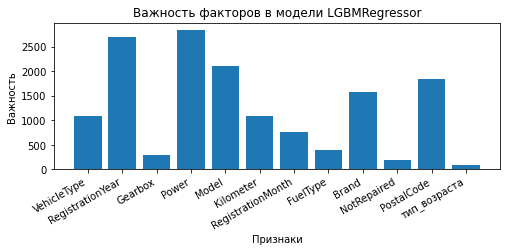

In [787]:
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(features_test.columns, model.feature_importances_)
fig.autofmt_xdate()

#подписи осей
plt.xlabel('Признаки')
plt.ylabel('Важность')

#заголовок
plt.title('Важность факторов в модели LGBMRegressor')

plt.show()

#### Внутренний метод кодировки данных LGBMRegressor

Используем внутренний метод кодирования категориальных признаков:

Составим список текстовых столбцов

In [788]:
obj_feat = list(df2.loc[:, df2.dtypes == 'object'].columns.values)
print(obj_feat)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'тип_возраста']


Изменим на тип данных "category"

In [789]:
for feature in obj_feat:
    df2[feature] = pd.Series(df2[feature], dtype="category")

Проверим работу модели без преобразования категориальных признаков

Повторим шаги с разбиеним выборки:

In [790]:
target = df2['Price']
features = df2.drop('Price', axis=1)

In [791]:
features_part, features_test, target_part, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) # отделим 20% (1/5) данных для тестовой выборки

In [792]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_part, target_part, test_size=0.25, random_state=12345) # отделим 25% (1/4) данных для валидации

In [793]:
features_train.shape, features_valid.shape, features_test.shape # проверим результат разбиения

((145167, 12), (48389, 12), (48390, 12))

In [794]:
features_train.head(3) #проверим результат

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,тип_возраста
42017,suv,2005,manual,141,tucson,150000,6,petrol,hyundai,no,26316,старая
4334,sedan,2006,auto,140,passat,150000,7,gasoline,volkswagen,no,26180,старая
143230,convertible,1990,manual,98,golf,150000,3,petrol,volkswagen,no,50825,ретро


##### Обучим модель LGBMRegressor с текстовыми категориальными признаками:

Обучим модель с текстовыми признаками, повторим шаги 2.4.3 - 2.4.6

##### Скорость обучения:

In [795]:
%%time

model = LGBMRegressor(random_state=12345,
                        n_estimators=best_est, # число деревьев
                        max_depth=depth, # глубина каждого дерева
                        boosting_type= 'gbdt')# инициализируем модель LGBMRegressor с параметрами n_estimators=est и max_depth=depth

model.fit(features_train, target_train) # обучим модель на тренировочной выборке

Wall time: 4.58 s


LGBMRegressor(max_depth=17, n_estimators=500, random_state=12345)

##### Скорость предсказания:

In [796]:
%%time
predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели LGBMRegressor на валидационной выборке: {:.1f}".format(result),
      "Количество деревьев: {:.1f}".format(best_est), "Максимальная глубина: {:.1f}".format(depth))

RMSE наилучшей модели LGBMRegressor на валидационной выборке: 1529.3 Количество деревьев: 500.0 Максимальная глубина: 17.0
Wall time: 1.09 s


##### Результат на тестовой выборке

In [797]:
%%time
predictions_test = model.predict(features_test) # предсказания модели на валидационной выборке
result = mean_squared_error(target_test, predictions_test) ** 0.5 # значение метрики rmse на валидационной выборке

print("RMSE наилучшей модели LGBMRegressor на валидационной выборке: {:.1f}".format(result),
      "Количество деревьев: {:.1f}".format(best_est), "Максимальная глубина: {:.1f}".format(depth))

RMSE наилучшей модели LGBMRegressor на валидационной выборке: 1501.8 Количество деревьев: 500.0 Максимальная глубина: 17.0
Wall time: 1.11 s


**`LGBMRegressor(category)`** на тестовой выборке:
- Обучение **`4740 ms`**
- Предсказание **`1030 ms`**
- RMSE  =  **`1501.8`**

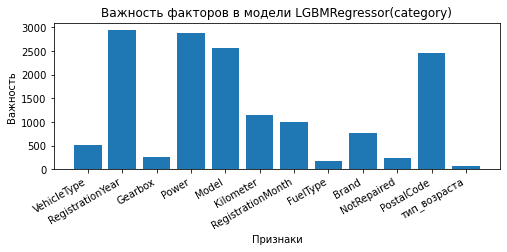

In [798]:
fig, ax = plt.subplots(figsize=(8,3))
ax.bar(features_test.columns, model.feature_importances_)
fig.autofmt_xdate()

#подписи осей
plt.xlabel('Признаки')
plt.ylabel('Важность')

#заголовок
plt.title('Важность факторов в модели LGBMRegressor(category)')

plt.show()

## Анализ моделей

Результаты предсказаний различных моделей сведены в таблице:

| параметр/модель | LinearRegression | DecisionTreeRegressor | RandomForestRegressor | LGBMRegressor |LGBMRegressor(category)
| --- | --- | --- | --- | --- | --- |
| Скорость обучения,  ms| 78.1 | 924 | 8460 | 3880 | 4740 |
| Скорость предсказания, ms| 6.98 | 28.9 | 182 | 768 | 1030 |
| RMSE, тыс.р.| 2873.9 | 1902.0 | 1656.1 | 1537.0 | 1501.8 |

Модель `LinearRegression` очень быстрая, но не точная. Модели `DecisionTreeRegressor` и `RandomForestRegressor` занимают промежутоные результаты, при этом RandomForestRegressor довольно точно предсказыает результат, но медленнее чем другие модели - более 8 секунд.

Самой удобной яляется модель `LGBMRegressor`, она показывает хороший результат даже с параметрами по умолчанию.

Важнейшим параметром предсказания является рыночная стоимость автомобиля за умеренное время, поэтому модель `LGBMRegressor` является самой подходящей. Она показывает более точный результат, затрачивая на обучение и предсказание менее 3х секунд.